## Import modules, data and packages

In [6]:
import models.road_network.create_graph as cg
import models.vehicle_models.energy_consumption as ec
import simulation.simulate_routes as sr
import json
import math
import pandas as pd
import random
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

Collect data, and config files

In [7]:

with open("models/vehicle_models/static_data.json", "r") as file:
    static_data = json.load(file)
with open("models/vehicle_models/vehicle_data.json", "r") as file:
    vehicle_data = json.load(file)
with open("models/vehicle_models/battery_data.json", "r") as file:
    battery_data = json.load(file)

with open("./data_collection/data/large_net/fixed_large_dis_data.json", "r") as file:
    map_data = json.load(file)
road_network_file = './data_collection/data/large_net/large_edge_data.csv' 
road_df = pd.read_csv(road_network_file)



Define key variables and compile graph

In [8]:
OCV = battery_data["OCV"]
capacity = battery_data["Capacity"]
R_int = battery_data["R_internal"]
motor_eff = vehicle_data["motor_eff"]


graph = cg.create_osmnx_compatible_graph(road_network_file, debug = False)
print(len(graph.edges))


3125


## Analyse Route and Collect Data

create a test set

In [9]:
import random

def create_test_set(u_list, v_list, num_pairs=200):
    # Combine both lists to get all available nodes
    all_nodes = u_list + v_list
    
    # Remove duplicates by converting to set and back to list
    unique_nodes = list(set(all_nodes))
    
    # Make sure we have enough nodes for the requested pairs
    if len(unique_nodes) < 2:
        raise ValueError("Not enough unique nodes to create pairs")
    
    # Create test set of random pairs
    test_set = []
    while len(test_set) < num_pairs:
        # Sample 2 nodes without replacement to ensure they're different
        node_pair = random.sample(unique_nodes, 2)
        
        # Create the tuple and add to test set
        pair = (node_pair[0], node_pair[1])
        
        # Optionally, check if this exact pair already exists in the test set
        # Uncomment if you want to ensure unique pairs
        if pair not in test_set and (pair[1], pair[0]) not in test_set:
            test_set.append(pair)
        
        # If you're close to exhausting all possible pairs, you might want to break
        # This is just a precaution and likely won't be needed with large graphs
        if len(test_set) == (len(unique_nodes) * (len(unique_nodes) - 1)) // 2:
            break
    
    return test_set

# test_set = create_test_set(road_df['u'].to_list(), road_df['v'].to_list())
# print(test_set)

Define test set.

In [10]:
test_set = [(5869437977, 2472524813), (10576730961, 6319406260), (1572010453, 280005573), (279742579, 6226125769), (6240370201, 956598303), (8270165433, 10658471691), (26070212, 4585717387), (26165150, 25991705), (843463020, 21529854), (26217250, 6058898375), (26151645, 26009744), (616942564, 10739447463), (2279742847, 4161700249), (3022068836, 4484476646), (26425162, 832782058), (1224377530, 732379115), (287227092, 10739497719), (1421871648, 26218274), (8408442976, 5409904699), (26165127, 2136439848), (26165152, 8007840936), (26425162, 4773779116), (465205538, 5914734949), (6148469042, 5312527696), (10739447463, 1970773874), (26466657, 830454815), (393143656, 963961960), (2892455961, 1751865178), (280010298, 3356986279), (26190457, 1097417876), (972935740, 2334396122), (26151656, 10751814850), (21037692, 26190497), (1022548134, 6433994021), (2460332277, 26170081), (26070211, 2189622273), (26165124, 3380845801), (2565672649, 26217254), (26170079, 966845899), (430269402, 4341744548), (966845899, 6824198862), (26165113, 430191416), (1975788450, 11865591910), (5885840414, 26160413), (10794808742, 26165101), (1436391229, 1885230900), (921648225, 1698355), (2971357803, 5569951805), (4590641788, 26164991), (2076171040, 4117553226), (26190507, 6192559883), (280003190, 17585264), (6831409058, 430666809), (26104434, 280003164), (4688567213, 5914735438), (10751814850, 4032728650), (26215522, 5869437927), (826838284, 1022548134), (1514665700, 5885840424), (5569951806, 430180490), (830599323, 826838284), (1203722130, 956598326), (840489772, 26149463), (393143659, 6343600441), (1036630663, 6157602586), (21531984, 830454725), (1097417905, 5879879532), (832782058, 5489858552), (1224377511, 3582048494), (981814755, 17705472), (2006482485, 26218283), (21529957, 5359925907), (280008965, 853556886), (280005484, 26151656), (2539000576, 367036281), (2214737730, 1986278327), (6071834338, 7065555301), (21032139, 6841851183), (6502743302, 26167335), (1692451190, 1052953636), (25954711, 18483296), (26190486, 26170079), (6824198859, 5359925907), (840488244, 21042461), (3033658145, 6343600442), (1969548497, 21310297), (1885230900, 2006482485), (4117553241, 4585717388), (17486537, 26165135), (2757541600, 26164040), (2189621006, 5438285327), (832782075, 1876656276), (1751865178, 21529949), (963961960, 891026747), (5359649074, 826838286), (1108314810, 826838271), (1419000235, 1108314693), (2076171054, 1422365759), (21031938, 2460332280), (1876656276, 830454826), (17705281, 4239199047), (435846331, 6058290567), (2892455930, 2472524832), (1775501534, 1044211088), (2565672654, 5308359053), (26164992, 2892455961), (4427052243, 3584572356), (25954712, 3001245508), (26104428, 17585126), (3356986279, 2298696536), (26160414, 840488244), (4906713454, 17705478), (430666457, 430672363), (4688614009, 1097417876), (280014599, 3101157631), (4565880110, 2565672658), (1127885350, 972935740), (26165128, 5869437927), (26170082, 26165099), (9662482584, 5359925908), (10751814837, 5941071864), (10283016082, 26165123), (4161700263, 26217283), (3355052507, 26070201), (12106287798, 1106626289), (6226125473, 242790322), (430180490, 21031938), (26151656, 5914735493), (430666918, 975789095), (21529953, 430668628), (3001245508, 26164992), (974624804, 6363663015), (26104404, 5517343420), (26070211, 6071834361), (26009748, 963961960), (10283016082, 26217224), (26009770, 6058981816), (5879879551, 4585717384), (17705489, 26104496), (4374643943, 5885840399), (26190468, 26170085), (21529896, 26165152), (4117553235, 21309758), (26166638, 7549842419), (8891802370, 17585143), (2297536205, 26165111), (4117553207, 26190520), (7192678490, 3584572365), (10935231431, 26215514), (17705281, 10935221495), (843463020, 26190490), (26150465, 4765573948), (1970090305, 26150474), (5410382639, 5879879549), (943619155, 1692444892), (10576730953, 2882717824), (1127885318, 26190520), (10794781027, 26164991), (280010106, 1968626170), (430685793, 4422870561), (3356986401, 4117553207), (1970773874, 279343253), (8007840937, 1227827624), (4117553235, 1913249541), (2279663502, 10935221491), (26190505, 6157602586), (4590641787, 26165120), (2004050917, 430663971), (21529896, 1227136497), (246189562, 1692451172), (26151648, 1969548497), (430179926, 6363663015), (833216544, 3022068836), (21031941, 26149467), (26165138, 10794781024), (430685705, 26104404), (26070189, 1422338809), (974883464, 21529980), (17585270, 12106877508), (1481290103, 2279682192), (6226125475, 26215516), (1108336044, 7737202757), (6502743303, 29175615), (3023519166, 3584572371), (4239199047, 10751814840), (6824198859, 21310297), (10751814837, 430179935), (2136439848, 430666745), (6319406265, 8898669707), (18483652, 2565672657), (686400062, 8265614351), (3001245522, 830454660), (2334396196, 25954711), (2941119306, 7066753267), (25954684, 26165100), (4765573948, 291583393), (26070240, 1203722130), (5274222101, 17487066), (26170075, 2279682197), (4585717385, 1127885291)]
test_set2 = [(1250717927, 1692451164), (5312151795, 4538695034), (5403763153, 6268584230), (1968626144, 6053223346), (6053456294, 1492538770), (26167352, 1692451190), (4117553202, 1080015168), (830599319, 279758537), (2214737568, 12106287798), (871619402, 3356986401), (2189622273, 974883464), (26104425, 5292486008), (10795344565, 1250717928), (1421871648, 279742579), (5517343420, 1694620777), (8067099900, 26190490), (1692451170, 1130578185), (17585269, 430685793), (974624804, 26165127), (25991705, 975863090), (8231098761, 21037684), (974590455, 5914735429), (6363663016, 1694620777), (1203722130, 5883070148), (280010380, 2074636585), (26165111, 279762296), (26151665, 2890143697), (1130492605, 1572010453), (21529964, 10935221495), (26190519, 3460374415), (826838284, 4906713454), (8007840936, 3033658149), (5410201339, 5885840424), (430180324, 2279682178), (5434038556, 6058898375), (6317196629, 1264685728), (246189562, 430668440), (3001245519, 1968626161), (280010106, 5941071863), (10794781022, 6471047441), (975696595, 26190518), (430269758, 6835921890), (1970090198, 26167354), (3033658145, 2205701895), (5156146590, 26167352), (3460374403, 6723462489), (4765573948, 5914862032), (21529981, 26151646), (7737202755, 1250715152), (26164045, 2990144218), (6074360729, 4688567213), (17705480, 5912770821), (1968626166, 26167328), (10794781024, 17487069), (921648231, 6071834341), (5519467253, 4773779115), (3001245520, 2076171029), (17585265, 5885840393), (1692444945, 430180427), (430180407, 25954684), (2800145702, 5885840424), (26104434, 5517369479), (247900624, 5409904699), (1127885291, 2990144218), (8265614352, 6053448276), (5433997113, 17585269), (10283016082, 5874434841), (1970090119, 10658471691), (26103649, 430672363), (26165103, 4218233651), (430180407, 833216529), (5499934229, 21309828), (280005414, 2971357803), (26174095, 10658471692), (10935231459, 1203722103), (280004730, 832782073), (2460332272, 616942564), (61316516, 18483657), (5517343625, 2334411823), (7549842418, 26151653), (830599232, 393143659), (5912770821, 280009758), (1587196525, 1224377530), (536801204, 1130492591), (21309828, 26103642), (4538695033, 830599329), (26070202, 26104404), (26167379, 2472524823), (26170079, 830454815), (3356986276, 1257809441), (830599226, 7066753267), (871619402, 26070181), (2279682192, 2990144219), (7113258773, 8067099900), (10935221491, 26234217), (6319406260, 26137502), (5489858553, 2279682182), (4590641787, 957704280), (826838277, 6058898376), (393143658, 17486550), (1986278325, 7549842418), (5519467268, 4740701184), (3022068891, 21531986), (1572010449, 3002126219), (4565880160, 2032872352), (6723460483, 842596956), (4422870536, 260968662), (21529979, 4538695034), (1108314810, 2076171058), (25991704, 2032872352), (6071834341, 4032728634), (4161700267, 1692451164), (3033658134, 429911356), (1968626134, 963961940), (12106877508, 3356986396), (10935231430, 833216530), (5410382639, 29172767), (6417777708, 286873768), (279343253, 61316516), (5519467286, 2539000576), (4585717385, 10751398349), (975794801, 8265614349), (5397167040, 5941071863), (2006482417, 957704261), (830599243, 1692444887), (3582048494, 1968626170), (830599351, 1052953636), (25932476, 6439781387), (18483296, 17408667), (26466677, 26190518), (4765573948, 21031942), (1775501535, 280010379), (6471047444, 8408442976), (5410247753, 4117553193), (26070229, 26165153), (11664929738, 1692444887), (1214768525, 2004050917), (6363663016, 25954686), (972935740, 26190497), (830454725, 5359925909), (4765573944, 26165107), (5885840393, 2018970217), (2214737529, 26070234), (1692444946, 4117553207), (2334396122, 399343667), (5211306824, 5274222105), (430191416, 26165115), (393143651, 3584572371), (1052953603, 4585717388), (975869584, 986084142), (7621555214, 2189621006), (2076171033, 5041068186), (4426224306, 26170075), (2076171050, 5434038556), (1587196507, 6051774215), (1694620777, 3380845809), (26165150, 26165124), (21032624, 4426224308), (61316516, 10751814723), (10751814844, 5223768383), (393143654, 2335487861), (1885230900, 4906713455), (8898669715, 5359925907), (4161700263, 26104474), (2460332280, 1436391093), (26165141, 430668635), (2214737671, 826838286), (10794808742, 26190234), (393143651, 10935231459), (26122193, 61316516), (4032728630, 832782047), (7065555299, 3584572362), (1421871641, 5041068186), (2004051104, 18483652), (7089876256, 1986278381), (1970090305, 17585265), (21309761, 2554326609), (2023344605, 430672363), (5914735469, 1224607038), (5517369480, 840488244), (17486555, 1052953667), (279752829, 26104426), (6343600453, 430666878), (1876656258, 6925711725), (1436391056, 26151649), (26104496, 26165120), (430668440, 8067099900), (8233623540, 6831409058), (5825992764, 5006106424), (10689370453, 6018428039), (17705491, 6226125476), (280005373, 10794781027), (26165154, 956598303), (830599254, 6925711725), (18483296, 21031941), (1108314693, 8235550079), (26150467, 4427052243), (1157134846, 21037686), (12057484711, 2882717824), (1572010468, 5274224230)]


In [11]:
small_test = [(1692451158, 2472524812), (17585126, 2076171054),(5403763153, 6268584230), (26165150, 25991705),(5885840414, 26160413),(1203722130, 5883070148), (6831409058, 430666809), (9662482584, 5359925908), (943619155, 1692444892), (2800145702, 5885840424), (6071834341, 4032728634), (4585717385, 1127885291), (12057484711, 2882717824),(4117553235, 21309758), (26166638, 7549842419), (8891802370, 17585143)]

explore relationship between OCV and total consumption.

In [12]:
weights_dict_opt1 = {'incline_weight': 0.25806589698012056, 'max_incline_weight': 2.385848873659276, 'distance_weight': 5.579483854494224, 'zero_start_weight': 13.982006857683707}
weights_dict_opt2 = {'incline_weight': 2.2845804889825976,
                        'max_incline_weight': 0.889801834962223,
                        'distance_weight': 5.296244459829336,
                        'zero_start_weight': 15.005629167085328}
new_weights =  {'incline_weight': 0.1, 'max_incline_weight': 0.1, 'distance_weight': 6.033896859128443, 'zero_start_weight': 7.502814583542664}

weights_dict_opt3 = {'incline_weight': 0.1, 'max_incline_weight': 3.2126752521839035, 'distance_weight': 4.755819765810573, 'zero_start_weight': 5.0}



In [13]:
# route = [10576730961, 10576730953, 1079987058, 26151648, 2460332280, 8891802368, 26151644, 21309761, 1080015179, 3033658141, 26167353, 3033658145, 26167347, 1250715152, 4426224306, 26165151, 1250715235, 10935221426, 26167335, 10935221491, 10935221495, 26167336, 10935231429, 10935231459, 26165130, 4150116225, 9568203082, 9568203077, 26165128, 26165125, 26165127, 4032728626, 26165148, 12106877508, 26215514, 26215513, 26215512, 5519467253, 1022548134, 25991707, 26070190, 26070189, 26218282, 26070172, 1015346553, 6326507990, 1015346535, 26009749, 4589377096, 6319406261, 6319406260]

# fig, ax = cg.plot_graph_with_colour_route(graph, route)
# plt.savefig('routediagram.jpg')
# plt.show()


[4585717385, 4585717386, 4585717387, 4585717379, 1986278336, 1986278333, 26070175, 26070171, 26070172, 26218282, 26070189, 26070190, 25991707, 1022548134, 5519467253, 26215512, 26215513, 26215514, 12106877508, 26165148, 1970090305, 17585267, 4484476616, 10283016088, 10283016082, 26165113, 4484476637, 1970090673, 26165120, 1421871685, 26165115, 6723460483, 1421871703, 26165116, 21309828, 840489772, 1139494217, 3380845801, 3380845804, 158387705, 1587196507, 1127885310, 1127885291]


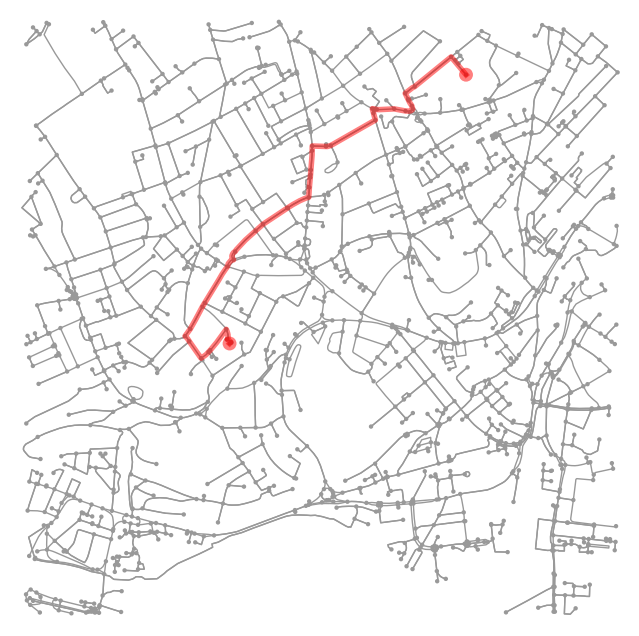

(2432.9430055537337, 6.556678771972656)

In [14]:
def test_weight_comparison(weights_dict, weighting, i):
    points = small_test[i]
    route_output = sr.find_route(map_data, road_df, graph, points[0], points[1], weights_dict, plot = True, weights_type=weighting)
    total_distance, total_consumption, total_climb, detailed_results, current_list, climbs, distances = sr.return_route_data_complex(route_output, vehicle_data, static_data, motor_eff, battery_data)

    return total_distance, total_climb

test_weight_comparison(weights_dict_opt1, 'distance', 12)

[1692451158, 963961964, 26104427, 26104426, 26104434, 5438285327, 963961980, 2298696536, 26159335, 17585146, 957754269, 17585143, 2971357803, 430715668, 246192208, 21529979, 830599351, 430178844, 17585126, 1130492591, 430269402, 430270406, 26070202, 17585264, 243078541, 465205538, 2892455909, 853556892, 26215513, 26215518, 26215519, 2882717824, 26170080, 26170079, 5517343419, 26170082, 2472524812]


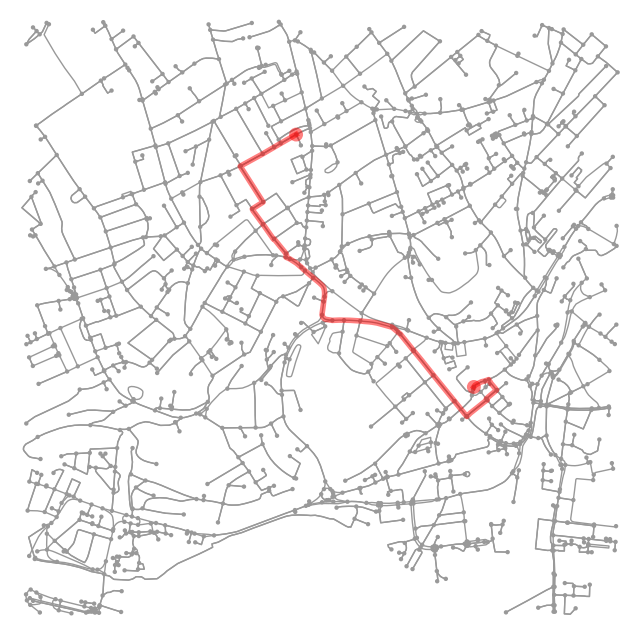

NetworkXNoPath: No path to 5397123541.

In [15]:
for i in range(len(small_test)):
    climb = test_weight_comparison(weights_dict_opt2,'objective',i)

In [ ]:
distance_consumptions = []
objective_consumptions = []
distance_current_lists = []
objective_current_lists = []
def simulate_routes():
    for i in range(len(test_set2)):
        try:
            objective_consumption, objective_current_list = test_weight_comparison(weights_dict_opt2,'objective',i)
            objective_consumptions.append(objective_consumption)
            objective_current_lists.append(objective_current_list)
        except:
            print(f"objective error route {i}")
        try:
            distance_consumption, distance_current_list = test_weight_comparison(weights_dict_opt2, 'distance',i)
            distance_consumptions.append(distance_consumption)
            distance_current_lists.append(distance_current_list)
        except:
            print(f"distance error route {i}")
        print(f'route {i} complete')

# simulate_routes()

In [ ]:
def sum_currents(lists):
    sums = []
    for list in lists:
        sums.append(sum(list))
    return(sum(sums))

def calc_perc_change(obj_value, dist_value):
    change = dist_value - obj_value
    perc_change = change/dist_value * 100

    return round(perc_change, 3), round(change, 3)

def print_simres():
    print(f'Number of routes analysed: {len(objective_current_lists)}')

    print("=====================Consumption=====================")
    print(f'Total for objective weighting: {sum(objective_consumptions)}Wh', f'Total for distance weighting: {sum(distance_consumptions)}Wh')
    perc_cons_change, cons_change = calc_perc_change(sum(objective_consumptions),sum(distance_consumptions))
    print(f'Percentage change: {perc_cons_change}%')

    print("=====================Current=====================")
    print(f'Total for objective weighting: {sum_currents(objective_current_lists)}A', f'Total for distance weighting: {sum_currents(distance_current_lists)}A')
    perc_cu_change, cu_change = calc_perc_change(sum_currents(objective_current_lists), sum_currents(distance_current_lists))
    print(f'Percentage change: {perc_cu_change}%')

# print_simres()


In [ ]:
def test_weight_comparison(weights_dict, weighting, i):
    points = test_set[i]
    route_output = sr.find_route(map_data, road_df, graph, points[0], points[1], 
                               weights_dict, plot=False, weights_type=weighting)
    total_distance, total_consumption, total_climb, detailed_results, current_list, climbs, distances = sr.return_route_data_complex(route_output, vehicle_data, static_data, motor_eff, battery_data)
    
    return total_consumption, current_list

def simulate_routes(weights_dict):
    obj_consumptions = []
    obj_current_lists = []
    dist_consumptions = []
    dist_current_lists = []
    
    for i in range(len(test_set)):
        try:
            # Pass weights_dict to both function calls
            dist_consumption, dist_current_list = test_weight_comparison(weights_dict, 'distance', i)
            obj_consumption, obj_current_list = test_weight_comparison(weights_dict, 'objective', i)
            
            dist_consumptions.append(dist_consumption)
            obj_consumptions.append(obj_consumption)
            dist_current_lists.append(dist_current_list)
            obj_current_lists.append(obj_current_list)
        except:
            print(f'route {i} no path')
        print(f'route {i} simulated')
    return {
        'objective_consumptions': obj_consumptions,
        'objective_current_lists': obj_current_lists,
        'distance_consumptions': dist_consumptions,
        'distance_current_lists': dist_current_lists
    }

def sum_currents(lists):
    sums = []
    for curr_list in lists:
        sums.append(sum(curr_list))
    return sum(sums)

def evaluate_weights(weights_dict):
    results = simulate_routes(weights_dict)
    
    obj_consumption_sum = sum(results['objective_consumptions'])
    obj_current_sum = sum_currents(results['objective_current_lists'])
    
    # You can also track distance-based metrics if needed
    dist_consumption_sum = sum(results['distance_consumptions'])
    dist_current_sum = sum_currents(results['distance_current_lists'])
    
    print(f"Weights: {weights_dict}")
    print(f"Objective - Consumption: {obj_consumption_sum}, Currents: {obj_current_sum}")
    print(f"Distance - Consumption: {dist_consumption_sum}, Currents: {dist_current_sum}")
    
    return obj_consumption_sum, obj_current_sum

In [ ]:
def test_parameter_sensitivity():
    # Base weights from your original configuration
    base = {"incline_weight": 4.0, "max_incline_weight": 4.0, 
            "distance_weight": 10.0, "zero_start_weight": 10.0}
    
    # Test ranges for each parameter
    test_values = np.linspace(0.1, 20.0, 5)  # 5 values from 0.1 to 20.0
    
    results = []
    
    # Test incline_weight
    for val in test_values:
        test_weights = base.copy()
        test_weights["incline_weight"] = val
        consumption, current = evaluate_weights(test_weights)
        combined = 0.5 * consumption + 0.5 * current
        results.append((f"incline_weight={val}", combined))
    
    # Test max_incline_weight
    for val in test_values:
        test_weights = base.copy()
        test_weights["max_incline_weight"] = val
        consumption, current = evaluate_weights(test_weights)
        combined = 0.5 * consumption + 0.5 * current
        results.append((f"max_incline_weight={val}", combined))
    
    # Test distance_weight
    for val in test_values:
        test_weights = base.copy()
        test_weights["distance_weight"] = val
        consumption, current = evaluate_weights(test_weights)
        combined = 0.5 * consumption + 0.5 * current
        results.append((f"distance_weight={val}", combined))
    
    # Test zero_start_weight
    for val in test_values:
        test_weights = base.copy()
        test_weights["zero_start_weight"] = val
        consumption, current = evaluate_weights(test_weights)
        combined = 0.5 * consumption + 0.5 * current
        results.append((f"zero_start_weight={val}", combined))
    
    # Sort by performance
    results.sort(key=lambda x: x[1])
    
    # Print results
    print("Parameter sensitivity analysis (best to worst):")
    for param, score in results:
        print(f"{param}: {score}")

# Run the analysis
# test_parameter_sensitivity()

In [ ]:
from skopt import gp_minimize, space
import numpy as np

# Define the objective function
def objective_function(weights_array):
    # Convert array of weights to dictionary
    weights_dict = {
        "incline_weight": weights_array[0],
        "max_incline_weight": weights_array[1],
        "distance_weight": weights_array[2],
        "zero_start_weight": weights_array[3]
    }
    
    # Evaluate the weights
    obj_consumption, obj_current = evaluate_weights(weights_dict)
    
    # You can adjust these coefficients to prioritize one metric over the other
    objective_value = 0.5 * obj_consumption + 0.5 * obj_current
    
    print(f"Combined objective: {objective_value}")
    return objective_value

# Define the search space
refined_space = [
    (0.1, 5.0),       # incline_weight - focus on lower values
    (0.1, 8.0),       # max_incline_weight - focus on lower to mid values
    (3.0, 8.0),       # distance_weight - narrow around the best performing value
    (10.0, 25.0)      # zero_start_weight - explore higher values
]

# Run the optimization with progress tracking
from skopt.callbacks import VerboseCallback

# First, evaluate the baseline
original_weights = {
    "incline_weight": 4.0,
    "max_incline_weight": 4.0,
    "distance_weight": 10.0,
    "zero_start_weight": 10.0
}

print("Evaluating original weights:")
baseline_consumption, baseline_current = evaluate_weights(original_weights)
baseline_objective = 0.5 * baseline_consumption + 0.5 * baseline_current
print(f"Baseline objective: {baseline_objective}")

# Now run the optimization with fewer iterations to start
print("\nStarting optimization:")
verbose_callback = VerboseCallback(n_total=50)
result = gp_minimize(
    objective_function, 
    refined_space, 
    n_calls=20,  # Reduced from 50 to make it faster
    callback=[verbose_callback],
    random_state=42
)

# Get and evaluate the best result
best_weights_array = result.x
best_weights = {
    "incline_weight": best_weights_array[0],
    "max_incline_weight": best_weights_array[1],
    "distance_weight": best_weights_array[2],
    "zero_start_weight": best_weights_array[3]
}

print("\nOptimization complete!")
print(f"Best weights found: {best_weights}")
print(f"Best objective value: {result.fun}")
print(f"Improvement over baseline: {(baseline_objective - result.fun) / baseline_objective * 100:.2f}%")

# Final evaluation of the best weights
print("\nFinal evaluation of best weights:")
evaluate_weights(best_weights)
 

ModuleNotFoundError: No module named 'skopt'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_parameter_exploration_compact(result):
    # Extract all evaluated points
    X = np.array(result.x_iters)
    y = np.array(result.func_vals)
    
    # Create a figure with a 2x2 grid of subplots
    param_names = [r'$w_i$ (incline weight)', 
                   r'$w_{max}$ (max incline weight)', 
                   r'$w_d$ (distance weight)', 
                   r'$w_z$ (zero start weight)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()  # Flatten to easily iterate
    
    # Color points by their objective value (darker = better)
    normalized_y = (y - np.min(y)) / (np.max(y) - np.min(y))
    colors = plt.cm.viridis(1 - normalized_y)
    
    # Plot each parameter's exploration
    for i, (ax, param_name) in enumerate(zip(axes, param_names)):
        # Extract this parameter's values
        param_values = X[:, i]
        
        # Scatter plot: x-axis is iteration, y-axis is parameter value
        iterations = range(1, len(param_values) + 1)
        sc = ax.scatter(iterations, param_values, c=colors, s=60, edgecolor='k')
        
        # Connect points to show exploration path
        ax.plot(iterations, param_values, 'k-', alpha=0.3)
        
        # Mark the best point found
        best_idx = np.argmin(y)
        ax.scatter(best_idx + 1, param_values[best_idx], 
                  color='red', s=120, marker='*', label='Best')
        
        # Show parameter bounds from the search space
        param_range = refined_space[i]
        ax.axhspan(param_range[0], param_range[1], alpha=0.1, color='blue')
        
        ax.set_xlabel('Iteration')
        ax.set_ylabel(param_name)
        ax.set_xlim(0.5, len(param_values) + 0.5)
        ax.grid(True, alpha=0.3)
        
        # Add the best value as text
        ax.text(len(iterations) * 0.7, param_values[best_idx], 
                f'Best: {param_values[best_idx]:.3f}', 
                fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
    
    # Add a colorbar for the objective value
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Performance')
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.suptitle('Parameter Exploration During Bayesian Optimisation', fontsize=14)
    plt.savefig('parameter_exploration_compact.png', dpi=300)
    plt.show()

# Call with your optimization result
plot_parameter_exploration_compact(result)

In [ ]:
with open("test_data/test_input_route.json", "w") as file:
    json.dump(route_output, file, indent=4)
# After your analysis:
with open("test_data/test_output.json", "w") as file:
    json.dump(detailed_results, file, indent=4, default=lambda x: float(x) if isinstance(x, np.float64) else (int(x) if isinstance(x, np.integer) else (bool(x) if isinstance(x, np.bool_) else (x.tolist() if isinstance(x, np.ndarray) else str(x) if not isinstance(x, (str, int, float, bool, list, dict, type(None))) else x))))